In [7]:
import pandas as pd
import numpy as np
import re
import random
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 或 ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False    # 正常显示负号

In [8]:
# 加载爬取的原始文本数据
def load_raw_data():
    """从文件或数据库加载原始文本数据"""
    # 选项1: 从CSV加载（没有标签列）
    # df = pd.read_csv('raw_threat_data.csv', names=['text'])
    
    # 选项2: 从文本文件加载（每行一个文档）
    with open('threat_texts.txt', 'r', encoding='utf-8') as f:
        texts = f.readlines()
    df = pd.DataFrame({'text': texts})
    
    # 选项3: 从数据库加载（示例）
    # import sqlite3
    # conn = sqlite3.connect('threat_intel.db')
    # df = pd.read_sql_query("SELECT content AS text FROM articles", conn)
    
    print(f"加载了 {len(df)} 条威胁舆情数据")
    return df

# 加载数据
df = load_raw_data()

# 查看数据示例
print("\n数据示例:")
print(df.head(3))

加载了 2200 条威胁舆情数据

数据示例:
                                                text
0  The dark side of 2023 Cybersecurity: Malware e...
1           January 25, 2024  |  Fernando Martinez\n
2  In the ever-evolving cybersecurity landscape, ...


In [9]:
def enhanced_preprocess(text):
    """
    增强版文本预处理:
    1. 清理特殊字符
    2. 标准化安全术语
    3. 提取关键实体
    """
    if not isinstance(text, str):
        return ""
    
    # 清理特殊字符
    text = re.sub(r'[^\w\s\.\-\:/\@]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    
    # 安全术语标准化
    replacements = {
        r'apt(\d+)': r'APT\1',  # 标准化APT命名
        r'cve-(\d{4})-(\d{4,7})': r'CVE-\1-\2',  # 标准化CVE
        r'(\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3})': r'IP地址_\1'  # 标记IP
    }
    
    for pattern, replacement in replacements.items():
        text = re.sub(pattern, replacement, text, flags=re.IGNORECASE)
    
    # 转换为小写
    text = text.lower()
    
    return text.strip()

# 应用预处理
df['clean_text'] = df['text'].apply(enhanced_preprocess)

# 查看处理后的数据
print("\n预处理后的文本示例:")
print(df['clean_text'].head(3))


预处理后的文本示例:
0    the dark side of 2023 cybersecurity: malware e...
1                    january 25 2024 fernando martinez
2    in the ever-evolving cybersecurity landscape 2...
Name: clean_text, dtype: object


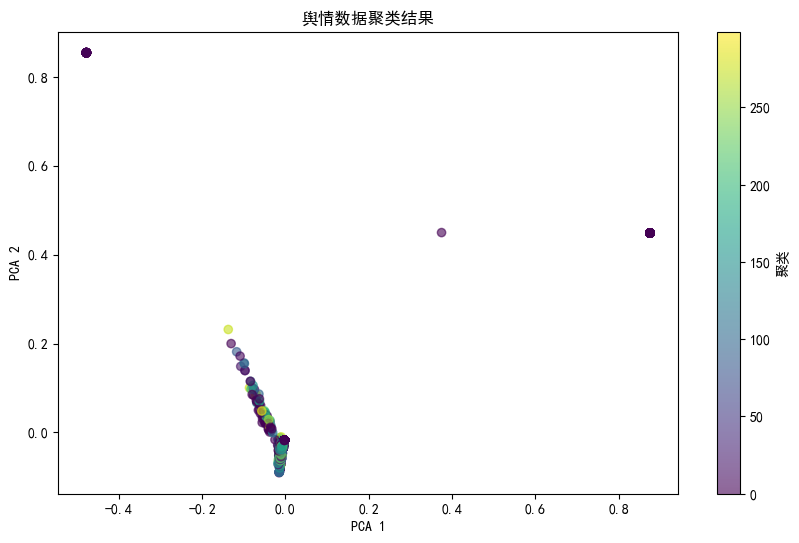

In [15]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 1. TF-IDF向量化
vectorizer = TfidfVectorizer(
    max_features=1000,
    ngram_range=(1, 2),
    stop_words=['is', 'are', 'so', 'and', 'but', 'because', 'the', 'a', 'an', 'to', 'of', 'in', 'for', 'on', 'with', 'at', 'by', 'this', 'that', 'it', 'as', 'from', 'be']
)
X = vectorizer.fit_transform(df['clean_text'])

# 2. 使用K-Means聚类
n_clusters = 300  # 假设有3种主要威胁类型
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(X)

# 3. 可视化聚类结果（降维）
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.6)
plt.title('舆情数据聚类结果')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(scatter, label='聚类')
plt.show()

# 4. 将聚类结果添加到DataFrame
df['cluster'] = clusters

In [16]:
# 分析每个聚类的关键词
def analyze_clusters(df, vectorizer, kmeans, n_words=10):
    """分析每个聚类的关键词"""
    feature_names = vectorizer.get_feature_names_out()
    cluster_keywords = {}
    
    print("\n聚类关键词分析:")
    for i in range(kmeans.n_clusters):
        # 获取聚类中心
        cluster_center = kmeans.cluster_centers_[i]
        
        # 获取最重要的关键词
        top_keyword_indices = cluster_center.argsort()[-n_words:][::-1]
        top_keywords = [feature_names[idx] for idx in top_keyword_indices]
        
        cluster_keywords[i] = top_keywords
        print(f"聚类 {i} 的关键词: {', '.join(top_keywords)}")
    
    return cluster_keywords

# 分析聚类
cluster_keywords = analyze_clusters(df, vectorizer, kmeans)

# 根据关键词定义标签
cluster_labels = {
    0: "威胁指标",  # 如果关键词包含CVE、IP、域名等
    1: "攻击技术",  # 如果关键词包含钓鱼、DDoS、勒索等
    2: "攻击者画像" # 如果关键词包含APT、组织、团伙等
}

# 添加标签到数据
df['label'] = df['cluster'].map(cluster_labels)

# 查看标签分布
print("\n标签分布:")
print(df['label'].value_counts())


聚类关键词分析:
聚类 0 的关键词: we, or, malware, lumma, malicious, threat, server, based, data, not
聚类 1 的关键词: sha256, sample, hash, zero, engineering, espionage, errata security, errata, environments, environment
聚类 2 的关键词: wallets, 20971520, appdata, targeted, localappdata, com, client, embedded, enterprises, evade
聚类 3 的关键词: dropper hash, malware dropper, dropper, hash, malware, entities, enterprise networking, enterprise software, enterprises, entire
聚类 4 的关键词: claim, 16, experts, 15, 10, 14, entities, enterprise software, enterprises, entire
聚类 5 的关键词: userdata, localappdata, browser, enterprise, evade, ethernet, espionage, errata security, errata, environments
聚类 6 的关键词: proxy, malware, windows, script, figure, service, application, system, exit, c2
聚类 7 的关键词: dll, virtual, sandbox, name, hash, decrypted, string, ntdll, strings, during
聚类 8 的关键词: exe, appdata, named, executed, windows, each, load, will, loader, remote
聚类 9 的关键词: about broadcom, about, broadcom, broadcom inc, inc, zero, ente